In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#kaggle.jsonをup
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
#データのダウンロード
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 95% 257M/271M [00:04<00:00, 71.3MB/s]
100% 271M/271M [00:04<00:00, 68.1MB/s]
100% 544M/544M [00:08<00:00, 77.1MB/s]

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 115MB/s]


In [0]:
!unzip train.zip > /dev/null 2>&1
!unzip test.zip > /dev/null 2>&1

In [0]:
import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import Model, Sequential
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.layers import Reshape, Conv2DTranspose
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

In [0]:
#画像の読み込み
X=[]
X_dog=[]
count=0
for num,filename in enumerate(os.listdir("train")):
    category = filename.split('.')[0]
    if category == 'cat':
        img = cv2.imread("train/{}".format(filename))
        #img = cv2.imread("train/{}".format(filename),cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        X.append(img)
 
    else:
      img = cv2.imread("train/{}".format(filename))
      #img = cv2.imread("train/{}".format(filename),cv2.IMREAD_GRAYSCALE)
      img=cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
      X_dog.append(img)
    
    
X = np.array(X)/255
X=X.astype("float32")
X_dog = np.array(X_dog)/255
X_dog=X_dog.astype("float32")
 

In [0]:
"""
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
original_dim = image_size * image_size
"""

In [8]:
X_train,X_valid=train_test_split(X[:10000],test_size=0.2, random_state=942)
print(X_train.shape)
print(X_valid.shape)

(8000, 128, 128, 3)
(2000, 128, 128, 3)


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
# network parameters
input_shape = (128,128,3)
image_size = X_train.shape[1]
original_dim = image_size * image_size
filters = 8
kernel_size = 3
batch_size = 128
latent_dim = 256
epochs = 10

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x=inputs
for i in range(4):
    filters *= 2    
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.25)(x)
    #x = Activation('relu')(x)
# shape info needed to build decoder model
shape = K.int_shape(x)

x = layers.Flatten()(x)
x = Dense(512, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(4):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2
    #x=BatchNormalization()(x)
    #x = Dropout(0.25)(x)
    #x=Activation('relu')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':

    # VAE loss = mse_loss or xent_loss + kl_loss
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    #reconstruction_loss = binary_crossentropy(K.flatten(inputs),
    #                                              K.flatten(outputs))
    
    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()
    
    vae.fit(X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=[X_valid,None])
    #vae.save_weights('vae_mlp_mnist.h5')
    #vae.fit(x_train,
    #        epochs=epochs,
    #        batch_size=batch_size,
    #        validation_data=[x_test,None])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 32)   4640        conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   18496       conv2d_11[0][0]                  
____________________________________________________________________________________________

In [0]:
z_mean, _, _ = encoder.predict(X_train[-10:],batch_size=batch_size)
x_decoded = decoder.predict(z_mean)

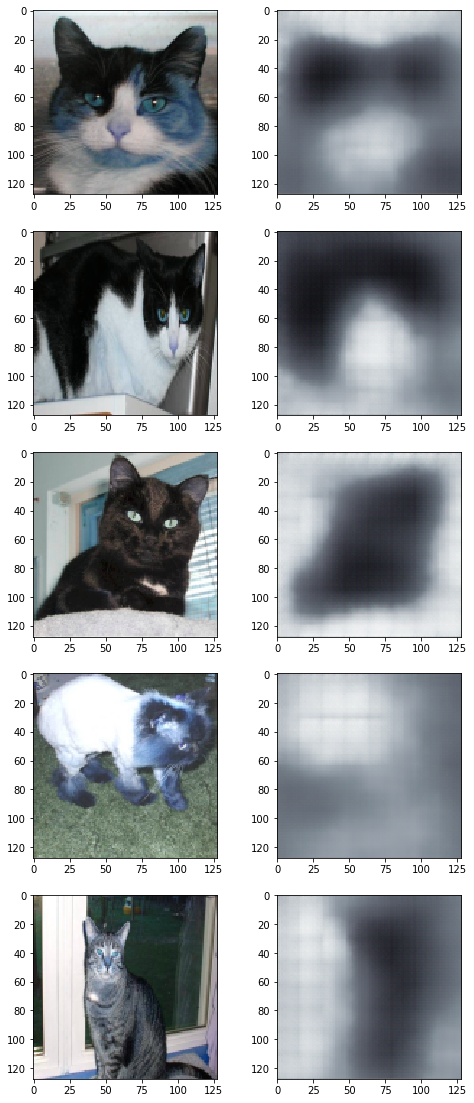

In [22]:
#画像の表示
plt.figure(figsize=(8,40))
for num,i in enumerate(range(5)):
    plt.subplot(10,2,num*2+1)
    plt.imshow(X_train[-10+i])
    plt.subplot(10,2,num*2+2)
    plt.imshow(x_decoded[i])
    #print(abs(X_train[i]-x_decoded[i]).sum())
plt.savefig("compare_samples.png")